# Generative Adversarial Network Example

Build a generative adversarial network (GAN) to generate digit images from a noise distribution with TensorFlow.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## GAN Overview

<img src="http://www.timzhangyuxuan.com/static/images/project_DCGAN/structure.png" alt="nn" style="width: 800px;"/>

References:
- [Generative adversarial nets](https://arxiv.org/pdf/1406.2661.pdf). I Goodfellow, J Pouget-Abadie, M Mirza, B Xu, D Warde-Farley, S Ozair, Y. Bengio. Advances in neural information processing systems, 2672-2680.
- [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html). X Glorot, Y Bengio. Aistats 9, 249-256

Other tutorials:
- [Generative Adversarial Networks Explained](http://kvfrans.com/generative-adversial-networks-explained/). Kevin Frans.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [191]:
# Classifier parameters
C_learning_rate = 0.01
C_training_epochs = 200
C_batch_size = 100
C_display_step = 20

# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Construct model
C_pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

# Minimize error using cross entropy
C_cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(C_pred), reduction_indices=1)) 

# Gradient Descent
C_optimizer = tf.train.GradientDescentOptimizer(C_learning_rate).minimize(C_cost)

In [192]:
# Generator training Params
num_steps = 70000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [193]:
# Store layers weight & bias
K = 10 #queue length
weights_list = []
biases_list = []

#for i in range(K):
weights_list += [{
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
},]

biases_list += [{
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
},]

In [194]:
# Generator
def generator_i(x,i):
    hidden_layer = tf.matmul(x, weights_list[i]['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases_list[i]['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights_list[i]['gen_out'])
    out_layer = tf.add(out_layer, biases_list[i]['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

def generator(x):
    out_layer_sum=0
    for i in range(min(len(weights_list),K)): # if not yet K learners, just sum up to n_iter
        out_layer_sum+=generator_i(x,i)
    return out_layer_sum/min(len(weights_list),K)

# Discriminator
def discriminator_i(x,i):
    hidden_layer = tf.matmul(x, weights_list[i]['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases_list[i]['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights_list[i]['disc_out'])
    out_layer = tf.add(out_layer, biases_list[i]['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

def discriminator(x):
    out_layer_sum=0
    for i in range(min(len(weights_list),K)):# if not yet K learners, just sum up to n_iter
        out_layer_sum+=discriminator_i(x,i)
    return out_layer_sum/min(len(weights_list),K)

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Update last weights/biases in list
# Generator Network Variables
gen_vars = [weights_list[0]['gen_hidden1'], weights_list[0]['gen_out'],
            biases_list[0]['gen_hidden1'], biases_list[0]['gen_out']]
# Discriminator Network Variables
disc_vars = [weights_list[0]['disc_hidden1'], weights_list[0]['disc_out'],
            biases_list[0]['disc_hidden1'], biases_list[0]['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [195]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

In [196]:
# Start classifier training
for epoch in range(C_training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/C_batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(C_batch_size)
        # Fit training using batch data
        _, c = sess.run([C_optimizer, C_cost], feed_dict={x: batch_xs,y: batch_ys})
        # Compute average loss
        avg_cost += c / total_batch
    # Display logs per epoch step
    if (epoch+1) % C_display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

print("Optimization Finished!")

# Test model
correct_prediction = tf.equal(tf.argmax(C_pred, 1), tf.argmax(y, 1))
# Calculate accuracy for test set
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
with sess.as_default():
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

Epoch: 0020 cost= 0.344164313
Epoch: 0040 cost= 0.315309885
Epoch: 0060 cost= 0.298480072
Epoch: 0080 cost= 0.287638919
Epoch: 0100 cost= 0.284633420
Epoch: 0120 cost= 0.279406072
Epoch: 0140 cost= 0.277407631
Epoch: 0160 cost= 0.274515240
Epoch: 0180 cost= 0.269936772
Epoch: 0200 cost= 0.267536111
Optimization Finished!
Accuracy: 0.9231


In [198]:
C_saver = tf.train.Saver([W,b])
C_saver.save(sess, "D:/School/NUS Y5/S2/Deep Learning/HW6/Regularization/saved/classifier_weights.ckpt")

'D:/School/NUS Y5/S2/Deep Learning/HW6/Regularization/saved/classifier_weights.ckpt'

In [154]:
# Start generator Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                                feed_dict=feed_dict)
    # Update weights/biases list
    # Update last item to be like second last    
    weights_list = [weights_list[0]] + weights_list
    biases_list = [biases_list[0]] + biases_list
    
    # Remove first item
    if len(weights_list) > K:
        weights_list.pop()
        biases_list.pop()
    
    if i % 1000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.348006, Discriminator Loss: 1.937679
Step 1000: Generator Loss: 3.333729, Discriminator Loss: 0.089854
Step 2000: Generator Loss: 4.550764, Discriminator Loss: 0.039372
Step 3000: Generator Loss: 5.537576, Discriminator Loss: 0.009592
Step 4000: Generator Loss: 3.397864, Discriminator Loss: 0.082919
Step 5000: Generator Loss: 4.032715, Discriminator Loss: 0.105085
Step 6000: Generator Loss: 3.286633, Discriminator Loss: 0.182369
Step 7000: Generator Loss: 3.584309, Discriminator Loss: 0.194608
Step 8000: Generator Loss: 4.039351, Discriminator Loss: 0.104186
Step 9000: Generator Loss: 3.869528, Discriminator Loss: 0.192289
Step 10000: Generator Loss: 3.547564, Discriminator Loss: 0.204406
Step 11000: Generator Loss: 3.834746, Discriminator Loss: 0.150512
Step 12000: Generator Loss: 3.976036, Discriminator Loss: 0.206273
Step 13000: Generator Loss: 3.481917, Discriminator Loss: 0.270362
Step 14000: Generator Loss: 2.785503, Discriminator Loss: 0.459059
Step 150

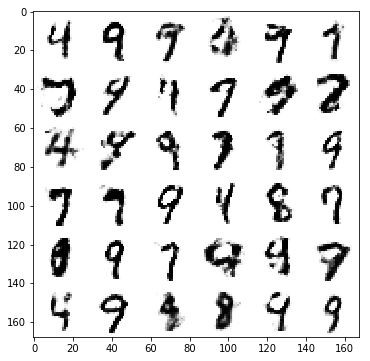

In [156]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

In [160]:
n_test=1000
for i in range(n_test):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n_test, noise_dim])
    # Generate image from noise.
    g_test = sess.run(gen_sample, feed_dict={gen_input: z})

In [159]:
saver1 = tf.train.Saver(weights_list[0])
saver1.save(sess, "D:/School/NUS Y5/S2/Deep Learning/HW6/Regularization/saved/chekhovgan_weights.ckpt")
saver2 = tf.train.Saver(biases_list[0])
saver2.save(sess, "D:/School/NUS Y5/S2/Deep Learning/HW6/Regularization/saved/chekhovgan_biases.ckpt")

'D:/School/NUS Y5/S2/Deep Learning/HW6/Regularization/saved/chekhovgan_biases.ckpt'

In [168]:
# classify generated images
y = tf.nn.softmax(tf.matmul(g_test, W) + b)
z = tf.argmax(y,1).eval(session=sess)

In [175]:
unique, counts = np.unique(z, return_counts=True)
dict(zip(unique, counts))

{0: 12, 1: 40, 2: 30, 3: 80, 4: 138, 5: 33, 6: 29, 7: 216, 8: 114, 9: 308}